In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy
import matplotlib.pyplot as plt
from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate



# -------------------------------
# 1. Data Generation (u(x))
# -------------------------------
m = 100    # Number of sensor points
n = 1000    # Number of random functions

x = np.linspace(0, 1, m)  # sensor locations

seed = MasterRNG(20250211)
def one_function(x):
    model = Gaussian(dim=1, var=3, len_scale=0.2)
    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

# Generate n random functions sampled at m points
U = np.zeros((m, n))
for i in range(n):
    U[:, i] = one_function(x)

# For physics-informed training, we only need u(x).
# Each sample will be a function u (of length m). 
# We take the columns of U (each of shape (m,)) as our dataset.
U_data = U.T  # shape: (n, m)
U_data = torch.tensor(U_data, dtype=torch.float32)

# -------------------------------
# 2. Define the DeepONet Architecture
# -------------------------------
class DeepONet(nn.Module):
    def __init__(self, m, hidden_dim=50, num_layers=5):
        """
        m: number of sensor points (dimension of input function u)
        hidden_dim: number of neurons per hidden layer (for both branch and trunk)
        num_layers: total number of layers (including the output layer)
        """
        super(DeepONet, self).__init__()
        self.m = m
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Build Branch Network: input dimension = m, output dimension = hidden_dim.
        layers_branch = []
        in_dim = m
        for i in range(num_layers - 1):
            layers_branch.append(nn.Linear(in_dim, hidden_dim))
            layers_branch.append(nn.Tanh())
            in_dim = hidden_dim
        layers_branch.append(nn.Linear(in_dim, hidden_dim))
        self.branch_net = nn.Sequential(*layers_branch)
        
        # Build Trunk Network: input dimension = 1, output dimension = hidden_dim.
        layers_trunk = []
        in_dim = 1
        for i in range(num_layers - 1):
            layers_trunk.append(nn.Linear(in_dim, hidden_dim))
            layers_trunk.append(nn.Tanh())
            in_dim = hidden_dim
        layers_trunk.append(nn.Linear(in_dim, hidden_dim))
        self.trunk_net = nn.Sequential(*layers_trunk)
        
        # Learnable bias
        self.bias = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, u, x):
        """
        u: (batch_size, m)  -- the input function discretized at m points.
        x: (batch_size, 1)  -- spatial locations at which to evaluate the operator.
        """
        branch_out = self.branch_net(u)      # shape: (batch_size, hidden_dim)
        trunk_out = self.trunk_net(x)          # shape: (batch_size, hidden_dim)
        out = torch.sum(branch_out * trunk_out, dim=1, keepdim=True) + self.bias
        return out



In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Assume U_data, x, and DeepONet along with the loss functions (operator_loss, physics_loss, total_loss) 
# are defined as in your previous code.

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model and send it to the device
model = DeepONet(m=m, hidden_dim=50, num_layers=5).to(device)

# -------------------------------
# 3. Define Physics-Informed Loss Functions (as provided)
# -------------------------------
def operator_loss(model, u_batch):
    """
    Enforces G_theta(u)(0) = 0.
    u_batch: (batch_size, m)
    """
    batch_size = u_batch.size(0)
    x0 = torch.zeros((batch_size, 1), device=u_batch.device)  # x=0 for each sample
    out = model(u_batch, x0)  # shape: (batch_size, 1)
    loss_op = torch.mean(out**2)
    return loss_op

def physics_loss(model, u_batch, sensor_x):
    """
    Enforces d/dx G_theta(u)(x) = u(x) at sensor locations.
    
    u_batch: (batch_size, m), where each row is u evaluated at sensor_x (of length m).
    sensor_x: (m, 1) tensor of sensor locations (common for all samples).
    """
    batch_size = u_batch.size(0)
    # Compute branch representation (does not depend on x)
    branch_out = model.branch_net(u_batch)  # shape: (batch_size, hidden_dim)
    
    # Ensure sensor_x requires grad so we can differentiate trunk_net
    sensor_x = sensor_x.to(u_batch.device)
    sensor_x.requires_grad_(True)  # shape: (m, 1)
    
    # Evaluate trunk network at sensor points
    trunk_out = model.trunk_net(sensor_x)  # shape: (m, hidden_dim)
    
    # Compute derivative of trunk_out with respect to sensor_x for each output neuron.
    d = trunk_out.size(1)
    trunk_derivs = []
    for k in range(d):
        grad_k = torch.autograd.grad(
            outputs=trunk_out[:, k],
            inputs=sensor_x,
            grad_outputs=torch.ones_like(trunk_out[:, k]),
            create_graph=True,
            retain_graph=True
        )[0]  # shape: (m, 1)
        trunk_derivs.append(grad_k)
    trunk_derivs = torch.cat(trunk_derivs, dim=1)  # shape: (m, hidden_dim)
    
    # For each sample, compute d/dx G_theta(u)(x) = branch_out dot [trunk_derivs(x)]^T.
    physics_pred = torch.matmul(branch_out, trunk_derivs.T)  # shape: (batch_size, m)
    
    # Enforce the constraint: derivative = u(x)
    loss_phys = torch.mean((physics_pred - u_batch)**2)
    return loss_phys

def total_loss(model, u_batch, sensor_x):
    return operator_loss(model, u_batch) + physics_loss(model, u_batch, sensor_x)

# -------------------------------
# 4. Prepare DataLoader and Train with Exponential LR Decay
# -------------------------------

# Create a dataset of u functions (each sample is of shape (m,))
# (U_data should be defined beforehand, e.g., U_data = torch.tensor(U.T, dtype=torch.float32))
batch_size = 10000
dataset = TensorDataset(U_data)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Prepare sensor points tensor (shape: (m, 1))
sensor_x = torch.tensor(x, dtype=torch.float32).view(m, 1)

# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Use LambdaLR so that lr = 0.001 * 0.9^(epoch/1000), i.e., decay by 0.9 every 1,000 iterations.
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9**(epoch//1000))

# Training loop
epochs = 40000  # total number of epochs (iterations, in this case)
train_losses = []

for epoch in range(epochs):
    model.train()
    loss_total_epoch = 0.0
    for (u_batch,) in train_loader:
        u_batch = u_batch.to(device)  # shape: (batch_size, m)
        optimizer.zero_grad()
        loss_val = total_loss(model, u_batch, sensor_x)
        loss_val.backward()
        optimizer.step()
        loss_total_epoch += loss_val.item()
    
    # Average the loss over the batches (only one batch in our case)
    loss_total_epoch /= len(train_loader)
    train_losses.append(loss_total_epoch)
    
    # Step the scheduler once per epoch
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch:5d} | Total Loss: {loss_total_epoch:.6f} | LR: {current_lr:.6e}")


Using device: cuda
Epoch     0 | Total Loss: 2.963527 | LR: 1.000000e-03
Epoch   100 | Total Loss: 1.162068 | LR: 1.000000e-03
Epoch   200 | Total Loss: 0.554234 | LR: 1.000000e-03
Epoch   300 | Total Loss: 0.255926 | LR: 1.000000e-03
Epoch   400 | Total Loss: 0.104761 | LR: 1.000000e-03
Epoch   500 | Total Loss: 0.093107 | LR: 1.000000e-03
Epoch   600 | Total Loss: 0.042830 | LR: 1.000000e-03
Epoch   700 | Total Loss: 0.034535 | LR: 1.000000e-03
Epoch   800 | Total Loss: 0.027863 | LR: 1.000000e-03
Epoch   900 | Total Loss: 0.014833 | LR: 1.000000e-03
Epoch  1000 | Total Loss: 0.014026 | LR: 9.000000e-04
Epoch  1100 | Total Loss: 0.012441 | LR: 9.000000e-04
Epoch  1200 | Total Loss: 0.011613 | LR: 9.000000e-04
Epoch  1300 | Total Loss: 0.011201 | LR: 9.000000e-04
Epoch  1400 | Total Loss: 0.011831 | LR: 9.000000e-04
Epoch  1500 | Total Loss: 0.009506 | LR: 9.000000e-04
Epoch  1600 | Total Loss: 0.007413 | LR: 9.000000e-04
Epoch  1700 | Total Loss: 0.006132 | LR: 9.000000e-04
Epoch  18

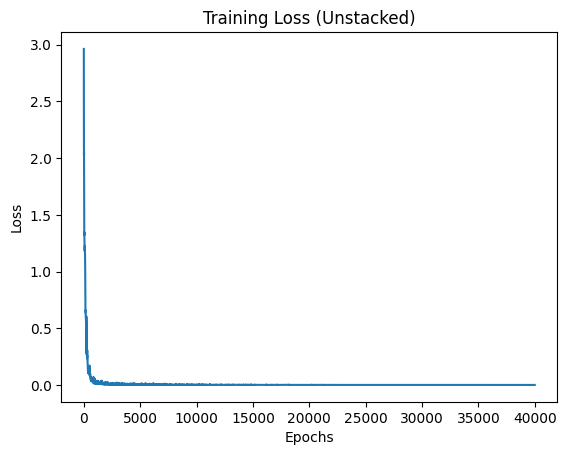

In [36]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss (Unstacked)")
plt.show()

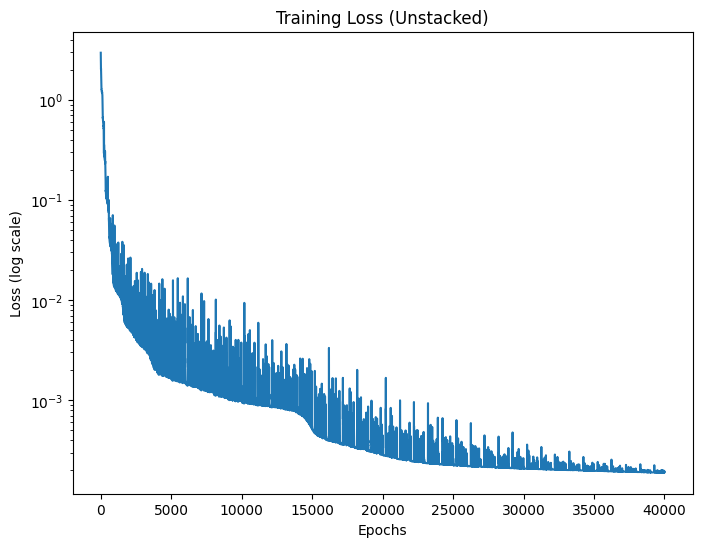

In [37]:
plt.figure(figsize=(8,6))
plt.plot(train_losses)
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss (Unstacked)")
plt.show()

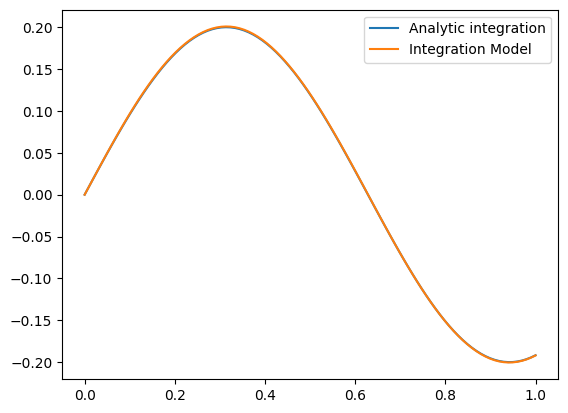

In [38]:
my_func = lambda x: np.cos(5*x)
inter = lambda x: 1/5*np.sin(5*x)
u_t = my_func(x)
s_t = inter(x)

model = model.to(device)
model.eval()
u_t_ = torch.tensor(u_t, dtype= torch.float32).unsqueeze(0).to(device)
x_ = torch.tensor(x, dtype = torch.float32).unsqueeze(1).to(device)
p = model(u_t_, x_)
p = p.detach().cpu().numpy()

plt.plot(x, s_t, label = "Analytic integration")
plt.plot(x, p, label = "Integration Model")
plt.legend();

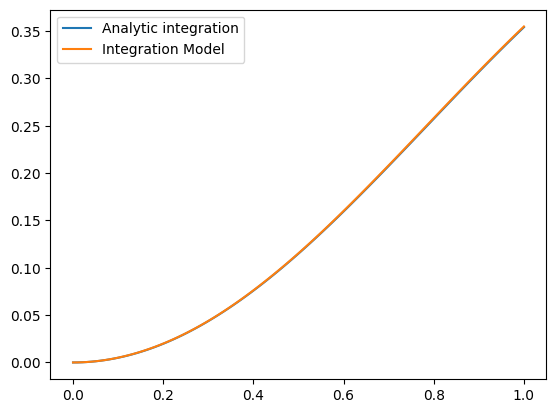

In [39]:
my_func = lambda x: np.cos(x)*np.sin(x)
inter = lambda x: 1/2*(np.sin(x))**2
u_t = my_func(x)
s_t = inter(x)

model = model.to(device)
model.eval()
u_t_ = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0).to(device)
x_ = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
p = model(u_t_, x_)
p = p.detach().cpu().numpy()

plt.plot(x, s_t, label = "Analytic integration")
plt.plot(x, p, label = "Integration Model")
plt.legend();